# YOLOv3 with OpenCV

## Download model weights
The file `yolov3.weight` containing the model weight is quite heavy in size i.e. `237 MB`.

In [1]:
![ -f 'yolov3.weights' ] && echo 'file exists' || wget 'https://pjreddie.com/media/files/yolov3.weights'

file exists


In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from os import path
import math

%matplotlib inline

## Initialize parameters

In [3]:
conf_threshold = 0.5  # confidence threshold
nms_threshold = 0.4   # non-maximum suppression threshold

inp_width = 608       # width of network's input image
inp_height = 608      # height of network's input image
inp_imsize = (inp_height, inp_width)

In [4]:
# load coco class names
classes_filepath = path.join('data', 'coco.names')
classes = None
with open(classes_filepath, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# give the configuration and weight files for the model and load the network using them.
model_configuration = path.join('cfg', 'yolov3.cfg')
model_weights = 'yolov3.weights'

yolov3 = cv.dnn.readNetFromDarknet(cfgFile=model_configuration, darknetModel=model_weights)
yolov3.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
yolov3.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

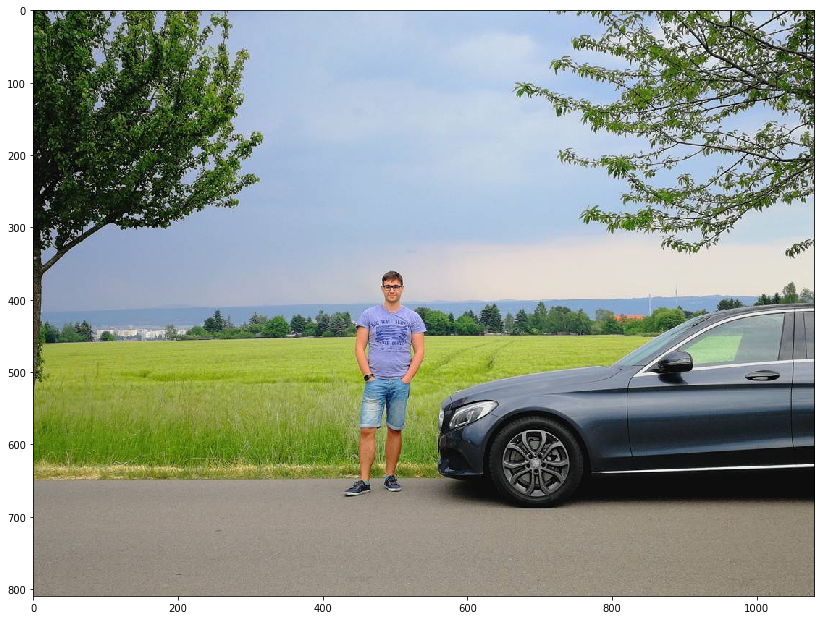

In [61]:
img = cv.imread('images/me.jpg', cv.IMREAD_COLOR)

plt.figure(figsize=(14, 13))
# convert image to RGB to show it correctly
plt.imshow(img[...,::-1])
plt.show()

In [54]:
# create a 4-dimensional Mat with NCHW dimensions order
blob = cv.dnn.blobFromImage(img, scalefactor=1/255.0, size=inp_imsize, mean=(0, 0, 0), swapRB=1, crop=False)

# setinput image intor the network
yolov3.setInput(blob)

In [55]:
# obtain names of all layers in the network
layer_names = yolov3.getLayerNames()

# array of all output layer names, i.e. the layers with unconnected outputs
output_names = [layer_names[ind - 1] for [ind] in yolov3.getUnconnectedOutLayers()]

print(f'outpult layer names: {output_names}')

outpult layer names: ['yolo_82', 'yolo_94', 'yolo_106']


## Forward pass into the YOLOv3 network

In [56]:
# run the forward pass to get output from the desired output layers
outs = yolov3.forward(output_names)
#outs = yolov3.forward(['yolo_82'])

In [57]:
max_id = len(classes)
colors =[(1, 0, 1), (0, 0, 1), (0, 1, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]

def get_color(cls_id):
    offset = float(cls_id*123457%max_id)
    ratio = offset/max_id*5
    i = math.floor(ratio)
    j = math.ceil(ratio)
    ratio -= i
    color = [int(255*((1-ratio)*colors[i][c] + ratio*colors[j][c])) for c in range(2, -1, -1)]
    return tuple(color)

709 person 0
728 car 2
2789 person 0
[0, 2, 0]
[0.9551211595535278, 0.9917023777961731, 0.9999426603317261]
[[427, 347, 117, 341], [543, 394, 541, 292], [440, 356, 101, 319]]


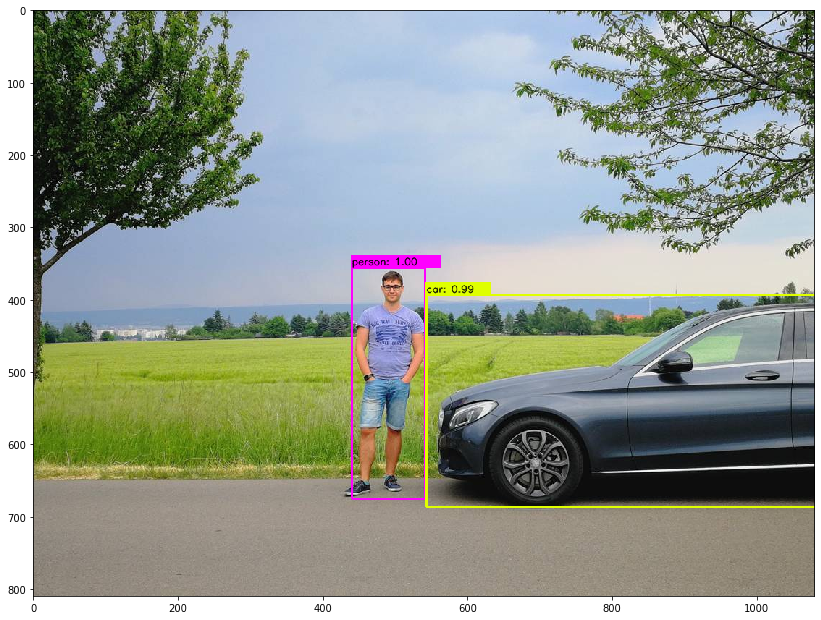

In [59]:
imh, imw = img.shape[:2]
# convert image to RGB to show it correctly
imdetection = cv.cvtColor(img, cv.COLOR_BGR2RGB)

cls_ids = []
confs = []
boxes = []

for out in outs:
    for i, detection in enumerate(out):       
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > conf_threshold:
            #print(i, len(detection), class_id)
            print(i, classes[class_id], class_id)
            cx, cy, w, h = detection[:4]        
            
            # get (left, top) and right, bottom) points 
            l = int((cx - w/2.)*imw)
            t = int((cy - h/2.)*imh)
            w = int(w*imw)
            h = int(h*imh)
            
            cls_ids.append(class_id)
            confs.append(float(confidence))
            boxes.append([l, t, w, h])

print(cls_ids)
print(confs)
print(boxes)
            
# Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
indices = cv.dnn.NMSBoxes(boxes, confs, conf_threshold, nms_threshold)            
            
for [i] in indices:    
    #color = (255, 178, 50)
    class_id = cls_ids[i]
    l, t, w, h = boxes[i]
    confidence = confs[i]
    
    color = get_color(class_id)
            
    cv.rectangle(imdetection, (l, t), (l+w, t+h), color, 2)
            
    label = f'{classes[class_id]}: {confidence:.2f}'

    # display the label at the top of the bounding box
    (lx, ly), bl = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    top = max(t, ly)
    cv.rectangle(imdetection, (l-1, t - round(1.5*ly)- bl), (l + round(1.5*lx), t ), color, cv.FILLED)
    cv.putText(imdetection, label, (l, t-bl), cv.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 0), 1, cv.LINE_AA)


plt.figure(figsize=(14, 13))
#plt.title('поня detection')
plt.imshow(imdetection)
plt.show()

In [60]:
len(classes)

80

In [13]:
classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']